In [1]:
import numpy as np
import math
import scipy.special as sp
from scipy import signal
from scipy.stats import circmean
from scipy.stats import linregress
import translational_utils as tu
import matplotlib.pyplot as plt

In [2]:
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

In [3]:
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 16}

plt.rc('font', **font)

In [4]:
# Import neuron labels
neuron_labels = np.genfromtxt('NEURON_LABELS.csv', delimiter=',', dtype=np.str)

In [5]:
pfnd_L_labels = neuron_labels[:,0:2]
pfnd_R_labels = neuron_labels[:,2:4]
pfnv_L_labels = neuron_labels[0:10,4:6]
pfnv_R_labels = neuron_labels[0:10,6:8]
hdeltab_labels = neuron_labels[0:19,8:12]

In [6]:
neuron_lookup = {}
neuron_lookup['PFND_L'] = pfnd_L_labels
neuron_lookup['PFND_R'] = pfnd_R_labels
neuron_lookup['PFNV_L'] = pfnv_L_labels
neuron_lookup['PFNV_R'] = pfnv_R_labels
neuron_lookup['HDELTAB'] = hdeltab_labels

In [7]:
hDeltaB_reordering = [10, 11, 12, 13, 14, 15, 16, 17, 18, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [8]:
def make_delb_readout(hdeltab_activity):
    
    rearranged_hdeltab = np.zeros(14)
    
    rearranged_hdeltab[0:3] = hdeltab_activity[hDeltaB_reordering][0:3]
    rearranged_hdeltab[3] = np.mean(hdeltab_activity[hDeltaB_reordering][3:5])
    rearranged_hdeltab[4] = np.mean(hdeltab_activity[hDeltaB_reordering][5:7])
    rearranged_hdeltab[5:9] = hdeltab_activity[hDeltaB_reordering][7:11]
    rearranged_hdeltab[9] = np.mean(hdeltab_activity[hDeltaB_reordering][11:14])
    rearranged_hdeltab[10] = np.mean(hdeltab_activity[hDeltaB_reordering][14:16])
    rearranged_hdeltab[11:] = hdeltab_activity[hDeltaB_reordering][16:]
    
    return rearranged_hdeltab

In [9]:
def get_angle(vec1, vec2):
    
    m1 = magnitude(vec1)
    m2 = magnitude(vec2)
    mdot = np.dot(vec1, vec2)
    mcross = np.sign(np.cross(vec1, vec2))
    
    return mcross*np.arccos(mdot/(m1*m2))

def magnitude(vec1):
    return math.sqrt(vec1[0]**2 +  vec1[1]**2)

def calc_PVA(z):
    
    # Can't assume that an hDeltaB neuron happens to align perfectly with zero
    # Shift the PVA calculation to reflect that the actual hDeltaB encoding doesn't
    # center on zero (based on a linear fit)
    m = 1.0046789786597556
    b = -10.62784572061546
    pva_shift = np.radians(b)

    encoding_angles = np.linspace(-np.pi-pva_shift, np.pi-pva_shift, 14, endpoint = False)
    encoding_xs = np.cos(encoding_angles)
    encoding_ys = np.sin(encoding_angles)

    decoded_x = np.dot(z, encoding_xs)
    decoded_y = np.dot(z, encoding_ys)

    decoded_angle = np.arctan2(decoded_y, decoded_x)
    return decoded_angle

In [10]:
def angle_diff(angle1, angle2):
    a = angle1 - angle2
    a = (a + 180) % 360 - 180
    return a

def wrap_to_360(angle, rads = False):

    if rads == True:
        angle = np.degrees(angle)
    
    while angle < 0.0:
        angle = angle + 360.0

    while angle >= 360.0:
        angle = angle - 360.0
        
    if rads == True:
        angle = np.radians(angle)

    return angle

vwrap = np.vectorize(tu.wrap_to_pi)

vangle_diff = np.vectorize(angle_diff)

In [11]:
# Do everything in degrees as soon as possible
def make_pva_allocentric_plot(pfn_index, title='', export_note=''):

    current_weights = pfn_weights[pfn_index]
    headings_to_plot = simulated_headings
    inputs_to_loop_through = all_input_info[pfn_index]
    
    data_by_heading = {new_list: [] for new_list in headings_to_plot}
    data_by_allo = {new_list: [] for new_list in single_direction_angles}
    all_xs = [] # allo
    all_ys = [] # pva
    
    for i in range(len(inputs_to_loop_through)):

        current_heading = np.round(inputs_to_loop_through[i][3])
        
        current_allo_direction = int(np.round(inputs_to_loop_through[i][0]))
        current_peak_position = pfn_peak_positions[pfn_index][i]
        current_pva = pfn_pvas[pfn_index][i]
        current_pva = np.degrees(current_pva)
        
        data_by_heading[current_heading].append([current_allo_direction, current_pva])
        data_by_allo[current_allo_direction].append(current_pva)
        
    n_colors = len(simulated_headings)
    color_cycle = plt.cm.jet(np.linspace(0.0, 1.0, n_colors))
    color_num = 0
    
    # Get the average PVA values per allocentric angle to plot
    avg_xs = []
    avg_ys = []
    
    for key in sorted(data_by_allo.keys()):
        avg_xs.append(key)
        avg_ys.append(circmean(data_by_allo[key], -180.0, 180.0))
        
    # Adjust all_ys so that angles much higher than avg_y for each allocentric direction
    # wrap around to be negative angles so that the linear regression works (i.e. adjust the
    # range to accommodate the linear regression)
    
    for v in range(len(avg_xs)):
        key = avg_xs[v]
        avg_y = avg_ys[v]
        y_data = data_by_allo[key]
    
    f, ax = plt.subplots(figsize = (7, 7))

    for heading_to_plot in headings_to_plot:

        plot_color = color_cycle[color_num]
        color_num+=1
        data_for_heading = np.transpose(data_by_heading[heading_to_plot])
        x = data_for_heading[0] # current allo direction
        y = data_for_heading[1] # current pva
        
        # Hardcoded wrapping for a nicer plot
        if current_weights[0]==1.0 and current_weights[1]==1.0:
            for u in range(len(x)):
                current_allo = x[u]
                y_index = np.where(avg_xs == current_allo)[0][0]
                avg_y = avg_ys[y_index]

                if current_allo-y[u] < -250.0:
                    y[u] = y[u]-360.0
                if -current_allo+y[u] < -250.0:
                    y[u] = y[u]+360.0
                    
        if current_weights[0]==0.0 and current_weights[1]==1.0 and heading_to_plot==0.0:
            for u in range(len(x)):

                if y[u] > 0.0:
                    y[u] = y[u]-360.0
                    
        if current_weights[0]==1.0 and current_weights[1]==0.0 and np.abs(heading_to_plot)==180.0:
            for u in range(len(x)):

                if y[u] < 0.0:
                    y[u] = y[u]+360.0

        plt.plot(x, y, '-', label = heading_to_plot, color = plot_color, linewidth=2)
    
    plt.xlabel('World-centric direction ('+u'\u00B0'+')')
    plt.ylabel('Population vector average of h'+u'\u0394'+'B activity ('+u'\u00B0'+')')
    plt.xlim(-200, 200)
    plt.ylim(-200, 200)
    plt.xticks(rotation=90)
    
    settings_desc='wPFND = '+str(current_weights[0])+' and wPFNV = '+str(current_weights[1])
    print(settings_desc)
    
    plt.title(title)
    
    ax.legend(title='heading (degrees)', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.savefig('4E_pva_vs_world_centric_travel_direction'+export_note+'.pdf', format='pdf')
    plt.show()

# Create Inputs

In [12]:
num_directions = 9 # number of allocentric directions
num_inputs = 9 # number of angles to sweep through for each allocentric direction
min_angle_sweep = -180.0
max_angle_sweep = 180.0

single_direction_inputs = {}
single_direction_angles = np.linspace(-180, 180, num_directions, endpoint=True)

for i in single_direction_angles:
    single_direction_inputs[i] = tu.make_fixed_allocentric_direction_inputs(i, num_inputs,
                                            min_angle_sweep = min_angle_sweep, max_angle_sweep = max_angle_sweep)

# Make PFND and PFNV weights

In [14]:
# [wPFND, wPFNV]
pfn_weights = [[1.0, 1.0], 
               [0.0, 1.0],
               [1.0, 0.0]]

# Run Simulations

In [15]:
noise_level = 0.01
filter_size = 3

pfn_ordered_results = []
pfn_processed_results = []
pfn_peak_positions = []
all_input_info = [] # allocentric dir, vf, vs, heading
pfn_pvas = []
pfnd_results = []
pfnv_results = []

for pfn_weight in pfn_weights:
    
    tu.set_PFND_weight(pfn_weight[0])
    tu.set_PFNV_weight(pfn_weight[1])
    setting = 'full_model'
    
    compiled_move_inputs = []
    compiled_allocentric_angles = []
    compiled_ordered_hdeltabs = []
    compiled_filtered_hdeltabs = []
    compiled_normalized_hdeltabs = []
    peak_positions = []
    peak_positions_filtered = []
    input_info = []
    pvas = []
    current_pfnd_contribution = []
    current_pfnv_contribution = []

    for i in single_direction_angles:

        move_inputs = single_direction_inputs[i]
        results = tu.run_hdeltab_simulation(move_inputs, 1000, noise_level=noise_level)
        HDELB_history = results[5]
        pfnd_contribution_history = results[6]
        pfnv_contribution_history = results[7]

        # Compile data from above
        for j in range(len(move_inputs)):

            input_info.append(np.hstack((i, move_inputs[j])))

            compiled_move_inputs.append(move_inputs[j])
            compiled_allocentric_angles.append(i)

            hdeltab_result = make_delb_readout(HDELB_history[j][-1])
            hdeltab_filtered = signal.medfilt(hdeltab_result, kernel_size = filter_size)
            peak_position = np.argmax(hdeltab_result)
            peak_position_filtered = np.argmax(hdeltab_filtered)

            compiled_ordered_hdeltabs.append(hdeltab_result)
            compiled_filtered_hdeltabs.append(hdeltab_filtered)
            compiled_normalized_hdeltabs.append(hdeltab_filtered/np.max(hdeltab_filtered))

            peak_positions.append(peak_position)
            peak_positions_filtered.append(peak_position_filtered)
            pvas.append(calc_PVA(hdeltab_result))
            
    pfn_processed_results.append(compiled_normalized_hdeltabs)
    pfn_ordered_results.append(compiled_ordered_hdeltabs)
    pfn_peak_positions.append(peak_positions_filtered)
    all_input_info.append(input_info)
    pfn_pvas.append(pvas)
    pfnd_results.append(current_pfnd_contribution)
    pfnv_results.append(current_pfnv_contribution)

# Plots

In [16]:
inputs_to_loop_through = all_input_info[0]
simulated_headings = set()

for i in range(len(inputs_to_loop_through)):
    simulated_headings.add(int(np.round(inputs_to_loop_through[i][3], 0)))
    
simulated_headings = sorted(simulated_headings)

wPFND = 1.0 and wPFNV = 1.0


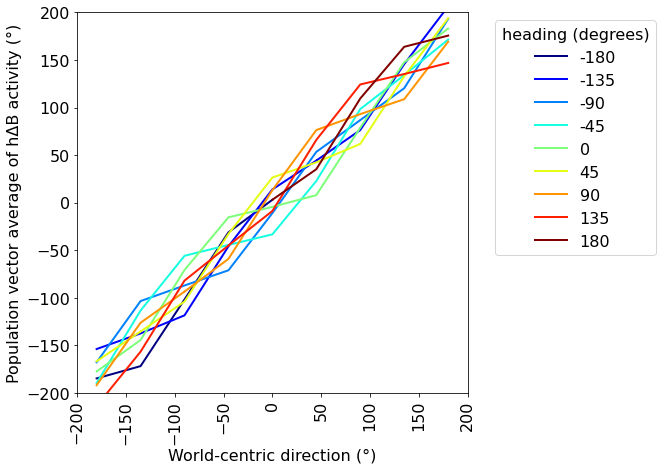

In [17]:
# Base model
pfn_ind = 0
make_pva_allocentric_plot(pfn_ind, export_note='_base_model')

wPFND = 0.0 and wPFNV = 1.0


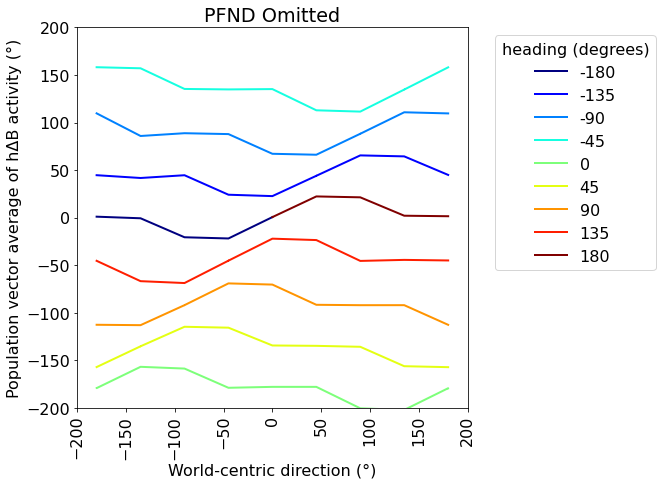

In [18]:
# PFND Omitted
pfn_ind = 1
make_pva_allocentric_plot(pfn_ind, title='PFND Omitted', export_note='_NoPFND')

wPFND = 1.0 and wPFNV = 0.0


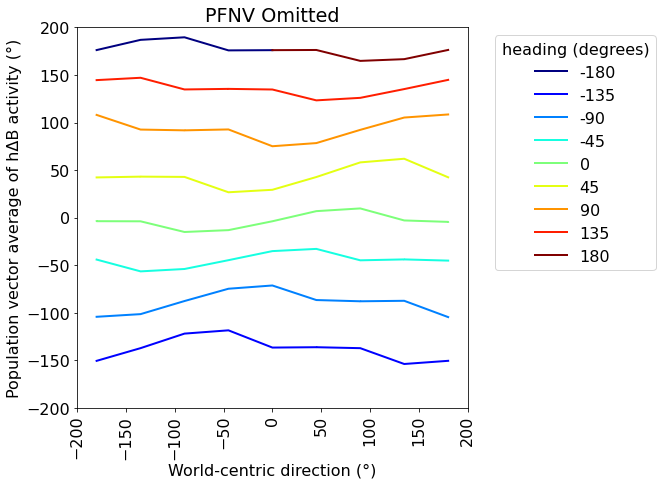

In [19]:
# PFNV Omitted
pfn_ind = 2
make_pva_allocentric_plot(pfn_ind, title='PFNV Omitted', export_note='_NoPFNV')

# Linearity with velocity

In [20]:
data_store = {}

In [21]:
allo_direction = 0.0
num_directions = 25
num_inputs = 7 # number of angles to sweep through for each allocentric direction
min_angle_sweep = -90.0
max_angle_sweep = 90.0
filter_size = 3

movement_inputs = tu.make_fixed_allocentric_direction_inputs(allo_direction, num_inputs,
                                            min_angle_sweep = min_angle_sweep, max_angle_sweep = max_angle_sweep)

In [22]:
tu.set_PFND_weight(1.0)
tu.set_PFNV_weight(1.0)

In [23]:
num_velocities = 12
velocities = range(0, num_velocities)

for i in range(len(movement_inputs)):
    
    compiled_move_inputs = []
    current_peak_amplitudes = []
    current_peak_amplitude_filtered = []
    
    input_template = movement_inputs[i]
    current_inputs = []
    
    for v in velocities:
        current_inputs.append([v*input_template[0], v*input_template[1], input_template[2]])
        
    results = tu.run_hdeltab_simulation(current_inputs, 1000, noise_level=noise_level)
    HDELB_history = results[5]
    
    for j in range(len(current_inputs)):

        compiled_move_inputs.append(current_inputs[j])
        hdeltab_result = make_delb_readout(HDELB_history[j][-1])
        hdeltab_filtered = signal.medfilt(hdeltab_result, kernel_size = filter_size)

        current_peak_amplitudes.append(np.max(hdeltab_result))
        current_peak_amplitude_filtered.append(np.max(hdeltab_filtered))
    
    data_store[int(np.round(movement_inputs[i][2], 0))]=[velocities, current_peak_amplitudes]

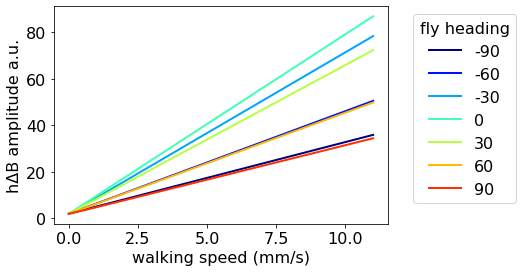

In [24]:
n_colors = 8
color_cycle = plt.cm.jet(np.linspace(0.0, 1.0, n_colors))
color_num = 0

plt.figure()

for i in range(len(movement_inputs)):

    data_name = int(np.round(movement_inputs[i][2], 0))
    plt.plot(data_store[data_name][0], data_store[data_name][1], '-', label = data_name, color = color_cycle[i], linewidth=2)

plt.xlabel('walking speed (mm/s)')
plt.ylabel('h'+u'\u0394'+'B amplitude a.u.')
plt.legend(title='fly heading', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.savefig('4D_hDeltaB_amplitude_vs_walking_speed.pdf', format='pdf')

plt.show()
